## Section 1: Setup & Configuration

In [1]:
# ============================================================================
# DEPENDENCIES INSTALLATION
# ============================================================================

!pip install jax jaxlib optax flax pandas numpy matplotlib seaborn scikit-learn -q

print("✓ JAX dependencies installed")

✓ JAX dependencies installed


In [2]:
# ============================================================================
# IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import os
from tqdm import tqdm

# JAX ecosystem
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import optax
from flax import linen as nn
from flax.training import train_state

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, 
    roc_curve, 
    auc, 
    roc_auc_score,
    classification_report
)
from sklearn.utils.class_weight import compute_class_weight

# Check JAX device
print(f"JAX version: {jax.__version__}")
print(f"Available devices: {jax.devices()}")
print(f"Default backend: {jax.default_backend()}")

# ============================================================================
# CONFIGURATION - TWO MOMENTUM RANGES FOR COMPARISON
# ============================================================================

RANDOM_SEED = 42
PARTICLE_NAMES = ['Pion', 'Kaon', 'Proton', 'Electron']
NUM_CLASSES = len(PARTICLE_NAMES)

# Define TWO momentum ranges to compare
MOMENTUM_RANGES = [
    {'min': 0.1, 'max': 999, 'name': 'Full Spectrum (0.1-∞ GeV/c)', 'key': 'full'},
    {'min': 1.0, 'max': 3.0, 'name': '1-3 GeV/c (Intermediate)', 'key': '1-3'}
]

BASE_DIR = '/kaggle/working'
SAVE_DIR = os.path.join(BASE_DIR, 'JAX_Models_Comparison')
os.makedirs(SAVE_DIR, exist_ok=True)

print(f"\n✓ Configuration loaded")
print(f"  Comparing TWO momentum ranges:")
for mr in MOMENTUM_RANGES:
    print(f"    - {mr['name']}")
print(f"  Target classes: {NUM_CLASSES}")
print(f"  Random seed: {RANDOM_SEED}")

# Dictionary to store results
all_results = {}

JAX version: 0.5.2
Available devices: [CudaDevice(id=0), CudaDevice(id=1)]
Default backend: gpu

✓ Configuration loaded
  Comparing TWO momentum ranges:
    - Full Spectrum (0.1-∞ GeV/c)
    - 1-3 GeV/c (Intermediate)
  Target classes: 4
  Random seed: 42


## Section 2: Data Loading & Preprocessing

In [3]:
# ============================================================================
# LOAD DATA (Once for both analyses)
# ============================================================================

CSV_PATH = '/kaggle/input/pid-features/pid_features_large.csv'

print("\nLoading data (shared for both analyses)...")
df_iter = pd.read_csv(CSV_PATH, dtype='float32', chunksize=500_000, low_memory=False)
df = pd.concat(df_iter, ignore_index=True)
print(f"✓ Loaded: {df.shape}")

# ============================================================================
# FUNCTION: Preprocess Data for Any Momentum Range
# ============================================================================

def preprocess_momentum_range(df, momentum_range):
    """
    Preprocess data for a specific momentum range
    Returns: X_train, X_test, y_train, y_test, scaler, available_features
    """
    print(f"\n{'='*80}")
    print(f"Processing: {momentum_range['name']}")
    print(f"{'='*80}")
    
    # Filter momentum range
    print(f"\nFiltering momentum range: {momentum_range['name']}")
    df_range = df[(df['pt'] >= momentum_range['min']) & 
                  (df['pt'] < momentum_range['max'])].copy()
    print(f"✓ Selected {len(df_range):,} tracks in range")
    
    # Handle missing values
    df_range.replace(-999, np.nan, inplace=True)
    
    tof_features = [col for col in df_range.columns if 'tof' in col.lower()]
    tpc_features = [col for col in df_range.columns if 'tpc' in col.lower()]
    bayes_features = [col for col in df_range.columns if 'bayes_prob' in col.lower()]
    
    # Fill missing values
    df_range[tof_features] = df_range[tof_features].fillna(0)
    df_range[tpc_features] = df_range[tpc_features].fillna(0)
    df_range[bayes_features] = df_range[bayes_features].fillna(0)
    
    # Create indicator features
    df_range['has_tof'] = (df_range[tof_features].abs().sum(axis=1) > 0).astype(int)
    df_range['has_tpc'] = (df_range[tpc_features].abs().sum(axis=1) > 0).astype(int)
    
    # Map PDG codes
    def pdg_to_species(pdg):
        ap = abs(int(pdg))
        if ap == 211:
            return 0
        elif ap == 321:
            return 1
        elif ap == 2212:
            return 2
        elif ap == 11:
            return 3
        else:
            return -1
    
    df_range['particle_species'] = df_range['mc_pdg'].apply(pdg_to_species)
    df_range = df_range[df_range['particle_species'] >= 0].reset_index(drop=True)
    
    print(f"✓ Valid particles: {len(df_range):,}")
    
    # ===== BACKGROUND CLEANING =====
    initial_count = len(df_range)
    
    # Momentum cuts
    df_range = df_range[(df_range['pt'] > 0.05) & 
                        (df_range['pt'] < 20)].copy()
    
    # DCA cuts
    dca_cut = 3.0
    df_range = df_range[(df_range['dca_xy'].abs() < dca_cut) & 
                        (df_range['dca_z'].abs() < dca_cut)].copy()
    
    # PID consistency
    nsigma_threshold = 5.0
    for particle in ['pi', 'ka', 'pr', 'el']:
        tpc_col = f'tpc_nsigma_{particle}'
        tof_col = f'tof_nsigma_{particle}'
        if tpc_col in df_range.columns and tof_col in df_range.columns:
            df_range = df_range[
                ~((df_range[tpc_col].abs() > nsigma_threshold) & 
                  (df_range[tof_col].abs() > nsigma_threshold))
            ].copy()
    
    print(f"\n✓ Background cleaning: {initial_count - len(df_range):,} tracks removed")
    print(f"  Clean dataset: {len(df_range):,} tracks ({len(df_range)/initial_count*100:.1f}% retained)")
    
    # Class distribution
    print(f"\nClass distribution:")
    class_counts = df_range['particle_species'].value_counts().sort_index()
    for idx, count in class_counts.items():
        print(f"  {PARTICLE_NAMES[idx]:10s}: {count:7,} ({count/len(df_range)*100:5.2f}%)")
    
    # ===== FEATURE SELECTION & SCALING =====
    training_features = [
        'pt', 'eta', 'phi', 'tpc_signal',
        'tpc_nsigma_pi', 'tpc_nsigma_ka', 'tpc_nsigma_pr', 'tpc_nsigma_el',
        'tof_beta',
        'tof_nsigma_pi', 'tof_nsigma_ka', 'tof_nsigma_pr', 'tof_nsigma_el',
        'bayes_prob_pi', 'bayes_prob_ka', 'bayes_prob_pr', 'bayes_prob_el',
        'dca_xy', 'dca_z',
        'has_tpc', 'has_tof'
    ]
    
    available_features = [f for f in training_features if f in df_range.columns]
    df_range = df_range.dropna(subset=available_features)
    
    X = df_range[available_features].astype('float32')
    y = df_range['particle_species'].values.astype('int32')
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y
    )
    
    print(f"\n✓ Train samples: {len(X_train):,}")
    print(f"✓ Test samples: {len(X_test):,}")
    
    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.values)
    X_test_scaled = scaler.transform(X_test.values)
    
    # Diagnostics
    print(f"\nFeature scaling diagnostics:")
    print(f"  Mean: {X_train_scaled.mean():.6f} (expect ~0)")
    print(f"  Std:  {X_train_scaled.std():.6f} (expect ~1)")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, available_features

# ============================================================================
# FUNCTION: Define Neural Network Model
# ============================================================================

class PIDNeuralNetwork(nn.Module):
    """Neural network for particle identification"""
    hidden_dims: list
    num_classes: int
    dropout_rate: float = 0.3
    
    @nn.compact
    def __call__(self, x, training: bool = False):
        z = x
        for i, dim in enumerate(self.hidden_dims):
            z = nn.Dense(dim, name=f'dense_{i}')(z)
            z = nn.relu(z)
            z = nn.Dropout(rate=self.dropout_rate, deterministic=not training)(z)
        logits = nn.Dense(self.num_classes, name='output')(z)
        return logits

print("\n✓ Functions and model defined")


Loading data (shared for both analyses)...
✓ Loaded: (4729393, 37)

✓ Functions and model defined


## Section 3: Training Function (Reusable)

In [6]:
# ============================================================================
# FUNCTION: Weighted Cross Entropy Loss
# ============================================================================

def weighted_cross_entropy_loss(logits, labels, class_weights):
    """Cross-entropy loss with class weighting"""
    one_hot_labels = jax.nn.one_hot(labels, NUM_CLASSES)
    log_softmax = jax.nn.log_softmax(logits, axis=-1)
    sample_weights = class_weights[labels]
    loss = -jnp.sum(one_hot_labels * log_softmax, axis=-1)
    weighted_loss = loss * sample_weights
    return jnp.mean(weighted_loss)

@jit
def train_step(state, batch_x, batch_y, dropout_key, class_weights):
    """Single training step"""
    def loss_fn(params):
        logits = state.apply_fn(
            {'params': params},
            batch_x,
            training=True,
            rngs={'dropout': dropout_key}
        )
        loss = weighted_cross_entropy_loss(logits, batch_y, class_weights)
        return loss
    
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

@jit
def eval_step(state, batch_x, batch_y):
    """Single evaluation step"""
    logits = state.apply_fn({'params': state.params}, batch_x, training=False)
    predictions = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(predictions == batch_y)
    return accuracy, logits

# ============================================================================
# FUNCTION: Train Model for One Momentum Range
# ============================================================================

def train_model(X_train_scaled, X_test_scaled, y_train, y_test, momentum_range_key):
    """Train a model on given data"""
    
    print(f"\n{'='*80}")
    print(f"TRAINING MODEL: {momentum_range_key}")
    print(f"{'='*80}")
    
    # Convert to JAX
    X_train_jax = jnp.array(X_train_scaled, dtype=jnp.float32)
    X_test_jax = jnp.array(X_test_scaled, dtype=jnp.float32)
    y_train_jax = jnp.array(y_train, dtype=jnp.int32)
    y_test_jax = jnp.array(y_test, dtype=jnp.int32)
    
    # Class weights
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = dict(enumerate(class_weights))
    class_weights_jax = jnp.array(list(class_weights_dict.values()), dtype=jnp.float32)
    
    print(f"\nClass weights:")
    for i, weight in class_weights_dict.items():
        print(f"  {PARTICLE_NAMES[i]:10s}: {weight:.4f}")
    
    # Initialize model
    key = random.PRNGKey(RANDOM_SEED)
    model = PIDNeuralNetwork(
        # hidden_dims=[256, 128, 64],
        hidden_dims=[512,256,128,64],
        num_classes=NUM_CLASSES,
        # dropout_rate=0.3
        dropout_rate=0.5
    )
    
    dummy_input = jnp.ones((1, X_train_jax.shape[1]))
    params = model.init(key, dummy_input, training=False)
    
    # Training state
    # learning_rate = 0.0005
    learning_rate = 0.0001
    tx = optax.adam(learning_rate)
    state = train_state.TrainState.create(
        apply_fn=model.apply,
        params=params['params'],
        tx=tx
    )
    
    # Training loop
    BATCH_SIZE = 256
    NUM_EPOCHS = 100
    PATIENCE = 15
    
    num_batches = len(X_train_jax) // BATCH_SIZE
    best_val_acc = 0.0
    patience_counter = 0
    
    train_losses = [
    val_accuracies = []
    main_key = key
    
    print(f"\nTraining (max {NUM_EPOCHS} epochs)...")
    
    for epoch in range(NUM_EPOCHS):
        main_key, shuffle_key, dropout_key = random.split(main_key, 3)
        
        perm = random.permutation(shuffle_key, len(X_train_jax))
        X_train_shuffled = X_train_jax[perm]
        y_train_shuffled = y_train_jax[perm]
        
        epoch_losses = []
        for batch_idx in range(num_batches):
            dropout_key, subkey = random.split(dropout_key)
            
            start_idx = batch_idx * BATCH_SIZE
            end_idx = start_idx + BATCH_SIZE
            
            batch_x = X_train_shuffled[start_idx:end_idx]
            batch_y = y_train_shuffled[start_idx:end_idx]
            
            state, loss = train_step(state, batch_x, batch_y, subkey, class_weights_jax)
            epoch_losses.append(loss)
        
        avg_train_loss = np.mean(epoch_losses)
        train_losses.append(avg_train_loss)
        
        val_acc, _ = eval_step(state, X_test_jax, y_test_jax)
        val_accuracies.append(float(val_acc))
        
        print(f"Epoch {epoch+1:3d}/{NUM_EPOCHS} | Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_params = state.params
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"✓ Early stopping at epoch {epoch+1}")
                break
    
    state = state.replace(params=best_params)
    
    # Final evaluation
    train_acc, train_logits = eval_step(state, X_train_jax, y_train_jax)
    test_acc, test_logits = eval_step(state, X_test_jax, y_test_jax)
    
    train_probs = jax.nn.softmax(train_logits, axis=-1)
    test_probs = jax.nn.softmax(test_logits, axis=-1)
    y_pred_test = jnp.argmax(test_logits, axis=-1)
    
    print(f"\n{'='*80}")
    print(f"RESULTS: {momentum_range_key}")
    print(f"{'='*80}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    
    # Store results
    results = {
        'model': state,
        'train_losses': train_losses,
        'val_accuracies': val_accuracies,
        'best_val_acc': best_val_acc,
        'train_acc': float(train_acc),
        'test_acc': float(test_acc),
        'train_logits': train_logits,
        'test_logits': test_logits,
        'train_probs': train_probs,
        'test_probs': test_probs,
        'y_pred_test': y_pred_test,
        'y_test': y_test_jax,
        'y_train': y_train_jax,
        'X_test': X_test_jax
    }
    
    return results

print("\n✓ Training function defined")


✓ Training function defined


## Section 4: Run Both Analyses

In [7]:
# ============================================================================
# RUN ANALYSIS FOR BOTH MOMENTUM RANGES
# ============================================================================

results_by_range = {}

for momentum_range in MOMENTUM_RANGES:
    mr_key = momentum_range['key']
    
    # Preprocess
    X_train_scaled, X_test_scaled, y_train, y_test, scaler, features = \
        preprocess_momentum_range(df, momentum_range)
    
    # Train
    results = train_model(X_train_scaled, X_test_scaled, y_train, y_test, mr_key)
    
    # Store
    results_by_range[mr_key] = {
        'momentum_range': momentum_range,
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler,
        'features': features,
        'results': results
    }

print(f"\n{'='*80}")
print("✓ BOTH ANALYSES COMPLETE")
print(f"{'='*80}")


Processing: Full Spectrum (0.1-∞ GeV/c)

Filtering momentum range: Full Spectrum (0.1-∞ GeV/c)
✓ Selected 4,729,392 tracks in range
✓ Valid particles: 4,163,954

✓ Background cleaning: 2,391,429 tracks removed
  Clean dataset: 1,772,525 tracks (42.6% retained)

Class distribution:
  Pion      : 1,451,225 (81.87%)
  Kaon      : 142,709 ( 8.05%)
  Proton    :  94,152 ( 5.31%)
  Electron  :  84,439 ( 4.76%)

✓ Train samples: 1,240,767
✓ Test samples: 531,758

Feature scaling diagnostics:
  Mean: 0.000000 (expect ~0)
  Std:  1.000000 (expect ~1)

TRAINING MODEL: full

Class weights:
  Pion      : 0.3053
  Kaon      : 3.1051
  Proton    : 4.7065
  Electron  : 5.2480

Training (max 100 epochs)...
Epoch   1/100 | Loss: 0.7328 | Val Acc: 0.5575
Epoch   2/100 | Loss: 0.6711 | Val Acc: 0.6051
Epoch   3/100 | Loss: 0.6565 | Val Acc: 0.5607
Epoch   4/100 | Loss: 0.6469 | Val Acc: 0.5855
Epoch   5/100 | Loss: 0.6417 | Val Acc: 0.5645
Epoch   6/100 | Loss: 0.6377 | Val Acc: 0.5753
Epoch   7/100 | L

## Section 5:  Comparison Visualisations


GENERATING COMPARISON VISUALIZATIONS



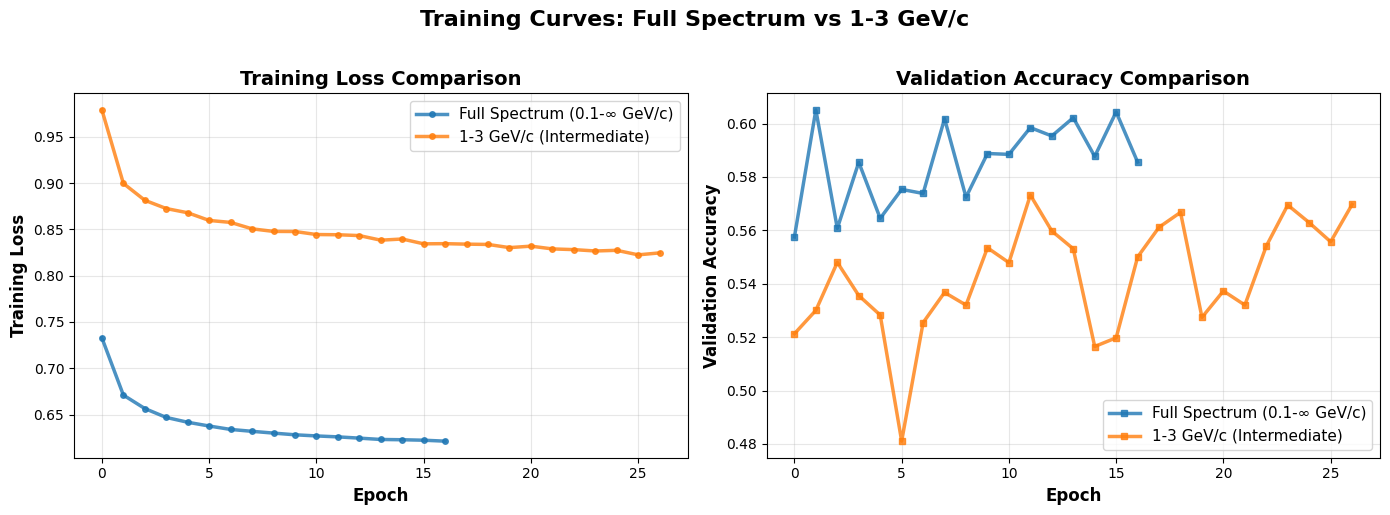

✓ Training curves comparison generated

FINAL METRICS COMPARISON TABLE

             Momentum Range Train Samples Test Samples Train Acc Test Acc Best Val Acc
Full Spectrum (0.1-∞ GeV/c)     1,240,767      531,758    0.6064   0.6051       0.6051
   1-3 GeV/c (Intermediate)       181,205       77,660    0.5725   0.5732       0.5732



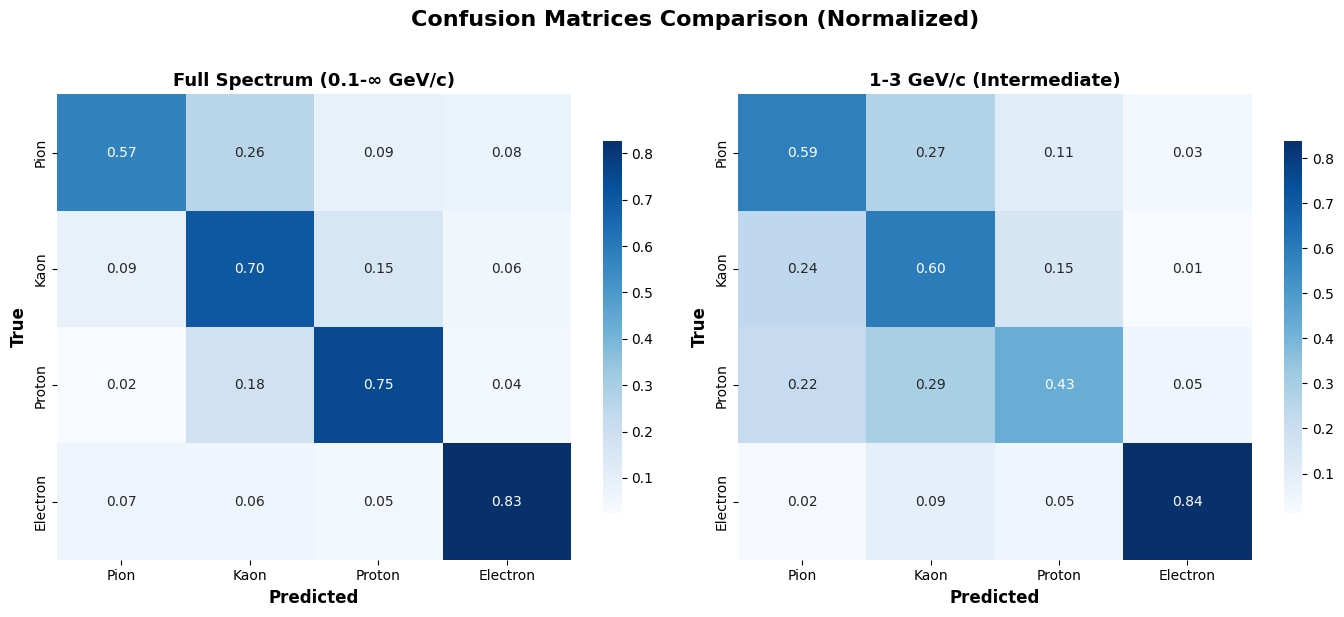

✓ Confusion matrices comparison generated


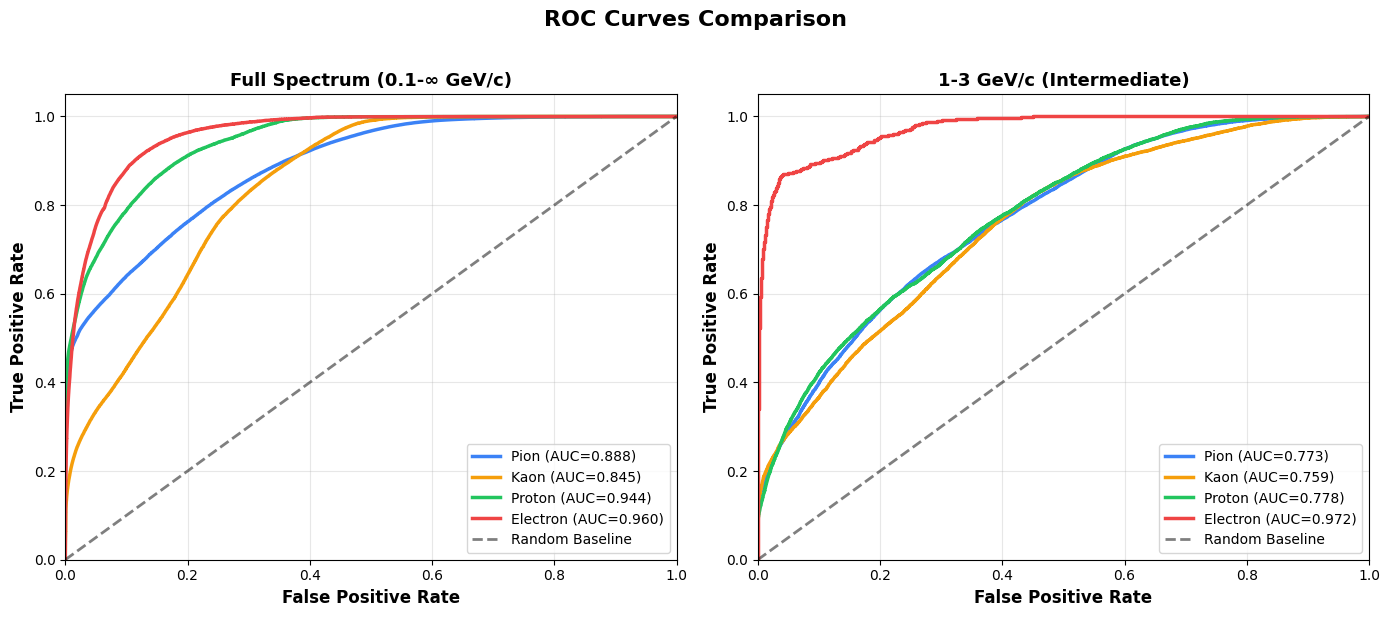

✓ ROC curves comparison generated


/tmp/ipykernel_48/4166559618.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(PARTICLE_NAMES, rotation=45, ha='right')
/tmp/ipykernel_48/4166559618.py:191: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(PARTICLE_NAMES, rotation=45, ha='right')


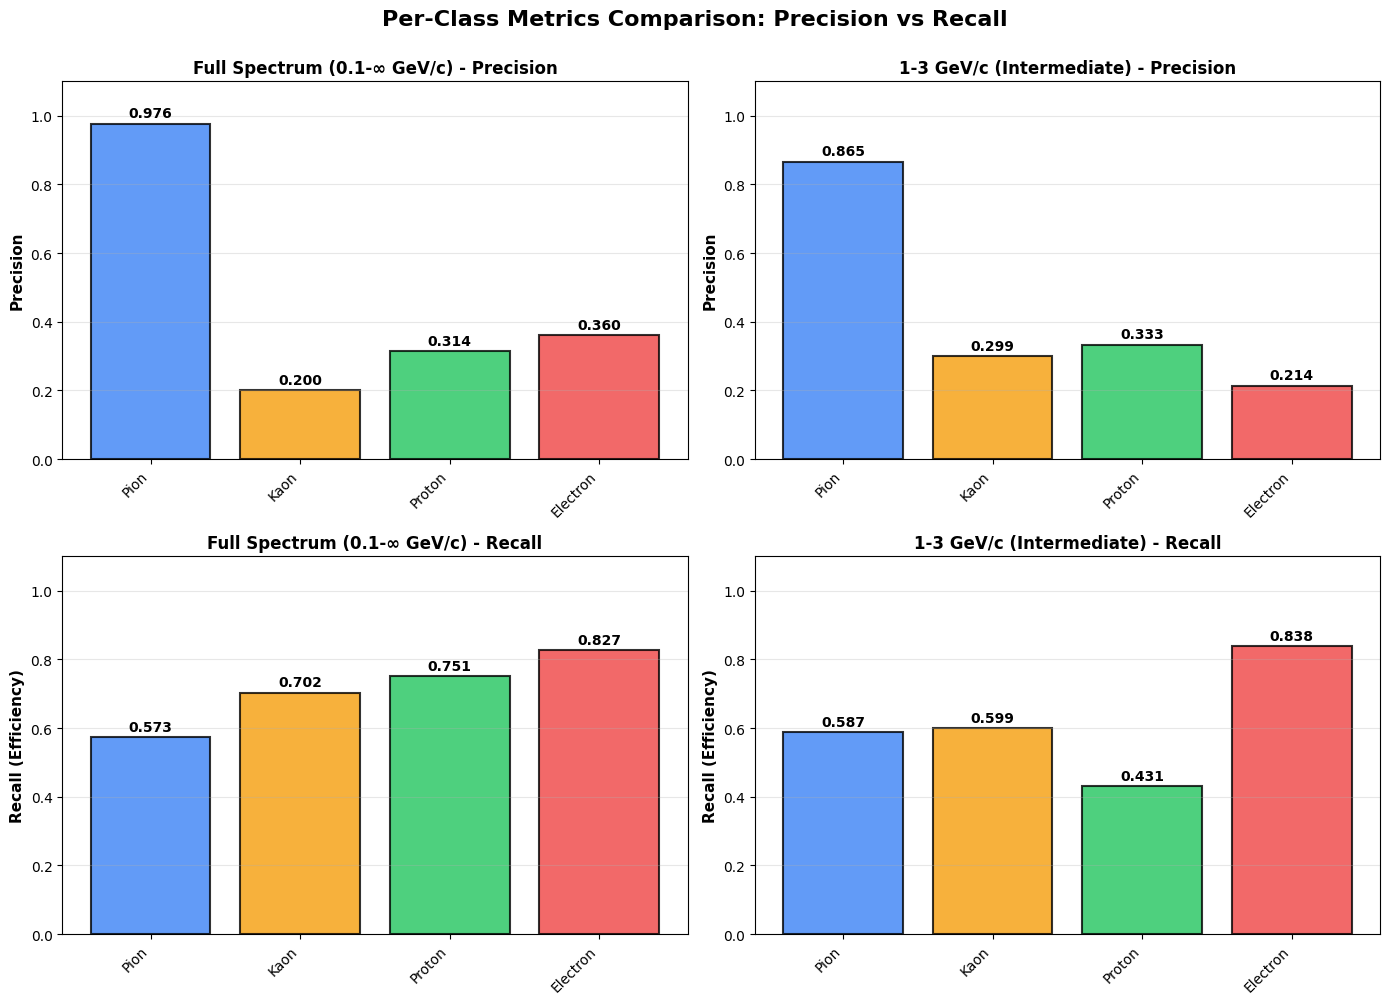

✓ Per-class metrics comparison generated

ANALYSIS COMPLETE - SUMMARY STATISTICS

FULL SPECTRUM (0.1-∞ GEV/C)
────────────────────────────────────────────────────────────────────────────────
  Train Accuracy:        0.6064
  Test Accuracy:         0.6051
  Best Validation Acc:   0.6051
  Train Samples:         1,240,767
  Test Samples:          531,758
  Total Samples:         1,772,525

1-3 GEV/C (INTERMEDIATE)
────────────────────────────────────────────────────────────────────────────────
  Train Accuracy:        0.5725
  Test Accuracy:         0.5732
  Best Validation Acc:   0.5732
  Train Samples:         181,205
  Test Samples:          77,660
  Total Samples:         258,865




In [11]:
# ============================================================================
# COMPARISON: TRAINING CURVES (LOSS & ACCURACY)
# ============================================================================

print(f"\n{'='*80}")
print("GENERATING COMPARISON VISUALIZATIONS")
print(f"{'='*80}\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for key, data in results_by_range.items():
    mr = data['momentum_range']
    results = data['results']

    train_losses = np.array(results['train_losses'])
    val_accuracies = np.array(results['val_accuracies'])

    axes[0].plot(train_losses, linewidth=2.5, label=mr['name'], marker='o', markersize=4, alpha=0.8)
    axes[1].plot(val_accuracies, linewidth=2.5, label=mr['name'], marker='s', markersize=4, alpha=0.8)

# Set labels and titles for left (0) and right (1) axes
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Training Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11, loc='best')
axes[0].grid(alpha=0.3)

axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
axes[1].set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11, loc='best')
axes[1].grid(alpha=0.3)

plt.suptitle('Training Curves: Full Spectrum vs 1-3 GeV/c', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✓ Training curves comparison generated")

# ============================================================================
# COMPARISON: FINAL METRICS TABLE
# ============================================================================

print(f"\n{'='*80}")
print("FINAL METRICS COMPARISON TABLE")
print(f"{'='*80}\n")

comparison_data = []
for key, data in results_by_range.items():
    mr = data['momentum_range']
    results = data['results']
    comparison_data.append({
        'Momentum Range': mr['name'],
        'Train Samples': f"{len(data['y_train']):,}",
        'Test Samples': f"{len(data['y_test']):,}",
        'Train Acc': f"{results['train_acc']:.4f}",
        'Test Acc': f"{results['test_acc']:.4f}",
        'Best Val Acc': f"{results['best_val_acc']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))
print()

# ============================================================================
# COMPARISON: CONFUSION MATRICES
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (key, data) in enumerate(results_by_range.items()):
    mr = data['momentum_range']
    results = data['results']
    y_test = data['y_test']
    y_pred = results['y_pred_test']
    
    cm = confusion_matrix(y_test, np.array(y_pred), normalize='true')
    
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=PARTICLE_NAMES,
                yticklabels=PARTICLE_NAMES,
                cbar_kws={'shrink': 0.8},
                ax=axes[idx],
                cbar=True)
    
    axes[idx].set_xlabel('Predicted', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True', fontsize=12, fontweight='bold')
    axes[idx].set_title(f'{mr["name"]}', fontsize=13, fontweight='bold')

plt.suptitle('Confusion Matrices Comparison (Normalized)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✓ Confusion matrices comparison generated")

# ============================================================================
# COMPARISON: ROC CURVES
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
colors = ['#3B82F6', '#F59E0B', '#22C55E', '#EF4444']

for plot_idx, (key, data) in enumerate(results_by_range.items()):
    mr = data['momentum_range']
    results = data['results']
    y_test = data['y_test']
    test_probs = results['test_probs']
    
    for i, (particle, color) in enumerate(zip(PARTICLE_NAMES, colors)):
        y_true_binary = (y_test == i).astype(int)
        y_score = np.array(test_probs[:, i])
        
        fpr, tpr, _ = roc_curve(y_true_binary, y_score)
        roc_auc = auc(fpr, tpr)
        
        axes[plot_idx].plot(fpr, tpr, color=color, lw=2.5, 
                           label=f'{particle} (AUC={roc_auc:.3f})')
    
    axes[plot_idx].plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5, label='Random Baseline')
    axes[plot_idx].set_xlim([0.0, 1.0])
    axes[plot_idx].set_ylim([0.0, 1.05])
    axes[plot_idx].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    axes[plot_idx].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    axes[plot_idx].set_title(f'{mr["name"]}', fontsize=13, fontweight='bold')
    axes[plot_idx].legend(loc='lower right', fontsize=10)
    axes[plot_idx].grid(alpha=0.3)

plt.suptitle('ROC Curves Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✓ ROC curves comparison generated")

# ============================================================================
# COMPARISON: PER-CLASS METRICS (PRECISION & RECALL)
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
colors = ['#3B82F6', '#F59E0B', '#22C55E', '#EF4444']

for plot_idx, (key, data) in enumerate(results_by_range.items()):
    mr = data['momentum_range']
    results = data['results']
    y_test = data['y_test']
    y_pred = results['y_pred_test']
    
    # Compute per-class metrics
    precisions = []
    recalls = []
    
    for i in range(NUM_CLASSES):
        y_true_binary = (y_test == i).astype(int)
        y_pred_binary = (np.array(y_pred) == i).astype(int)
        
        tp = np.sum((y_true_binary == 1) & (y_pred_binary == 1))
        fp = np.sum((y_true_binary == 0) & (y_pred_binary == 1))
        fn = np.sum((y_true_binary == 1) & (y_pred_binary == 0))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
    
    # Top row: Precision
    ax = axes[0, plot_idx]
    
    bars1 = ax.bar(PARTICLE_NAMES, precisions, color=colors, alpha=0.8, 
                    edgecolor='black', linewidth=1.5)
    for bar, val in zip(bars1, precisions):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax.set_ylabel('Precision', fontsize=11, fontweight='bold')
    ax.set_title(f'{mr["name"]} - Precision', fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(PARTICLE_NAMES, rotation=45, ha='right')
    
    # Bottom row: Recall
    ax = axes[1, plot_idx]
    
    bars2 = ax.bar(PARTICLE_NAMES, recalls, color=colors, alpha=0.8, 
                    edgecolor='black', linewidth=1.5)
    for bar, val in zip(bars2, recalls):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax.set_ylabel('Recall (Efficiency)', fontsize=11, fontweight='bold')
    ax.set_title(f'{mr["name"]} - Recall', fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(PARTICLE_NAMES, rotation=45, ha='right')

plt.suptitle('Per-Class Metrics Comparison: Precision vs Recall', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("✓ Per-class metrics comparison generated")

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print(f"\n{'='*80}")
print("ANALYSIS COMPLETE - SUMMARY STATISTICS")
print(f"{'='*80}\n")

for key, data in results_by_range.items():
    mr = data['momentum_range']
    results = data['results']
    
    print(f"{mr['name'].upper()}")
    print(f"{'─'*80}")
    print(f"  Train Accuracy:        {results['train_acc']:.4f}")
    print(f"  Test Accuracy:         {results['test_acc']:.4f}")
    print(f"  Best Validation Acc:   {results['best_val_acc']:.4f}")
    print(f"  Train Samples:         {len(data['y_train']):,}")
    print(f"  Test Samples:          {len(data['y_test']):,}")
    print(f"  Total Samples:         {len(data['y_train']) + len(data['y_test']):,}")
    print()

print(f"{'='*80}\n")